In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
X = np.load("data/emnist_ab/images_train.npy")
y = np.load("data/emnist_ab/labels_train.npy")
X_test = np.load("data/emnist_ab/images_test.npy")
y_test = np.load("data/emnist_ab/labels_test.npy")

In [5]:
pd.Series(y).value_counts() # Seulement dix images de chaque classe !

1    10
0    10
dtype: int64

In [6]:
# Il faut séparer encore le train en deux (créer un validation set) pour pouvoir vérifier que l'on overfit pas trop
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, shuffle=True, stratify=y)

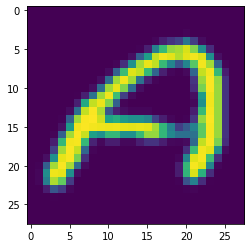

In [7]:
plt.imshow(X_train[0].squeeze())

Si l'on tente d'entraîner un modèle d'une taille importante sur les 10 images dont on dispose, il tombera dans le sur-apprentissage très rapidement.

Il faut donc utiliser plusieurs méthodes pour limiter cela :
- Utiliser un modèle avec peu de paramètres / très régularisé : Vous pouvez utiliser `model.summary()` pour vérifier le nombre de paramètres entraînables du modèle, il doit être petit afin de limiter l'overfitting.
- Utiliser le validation set pour arrêter l'entraînement quand la loss sur le validation set commence à remonter : cela s'appelle l'Early Stopping.

In [43]:
# Construire et compiler ici votre modèle.
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(2, activation='linear'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [44]:
# Afficher ici le summary du modèle
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 28)                21980     
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 58        
Total params: 22,038
Trainable params: 22,038
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Entraîner ici votre modèle
model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)],
)

Epoch 1/30
1/1 [==============================] - 0s 99ms/step - loss: 72.8511 - accuracy: 0.4000 - val_loss: 27.9871 - val_accuracy: 0.7000
Epoch 2/30
1/1 [==============================] - 0s 39ms/step - loss: 27.9101 - accuracy: 0.6000 - val_loss: 27.9628 - val_accuracy: 0.7000
Epoch 3/30
1/1 [==============================] - 0s 33ms/step - loss: 11.2786 - accuracy: 0.9000 - val_loss: 32.9635 - val_accuracy: 0.8000


In [46]:
# Evaluation du modèle
## Attention : dans cette mise en situation, l'entreprise n'a accès qu'à très peu d'images, c'est le coeur du problème.
## Le test set que nous utilisons dans ce notebook n'existe donc pas dans la mise en situation.
## Il représente le monde réel et tous les autres A et B que l'algorithme devra traiter après avoir été entraîné.
## Il faut donc l'utiliser le moins de fois possible dans cet exercice et il ne doit surtout pas être utilisé
## pour décider quel modèle utiliser.
## Pour cela, fiez-vous à votre validation set.
model.evaluate(X_test, y_test)

212/212 [==============================] - 0s 1ms/step - loss: 34.3016 - accuracy: 0.6551


[34.3016242980957, 0.6550502181053162]

Chez moi, le modèle atteint déjà une accuracy de 60-65%. C'est déjà la preuve qu'il apprend mais on peut faire mieux.

Avec data augmentation :

In [50]:
# Utilisez tf.keras.preprocessing.image.ImageDataGenerator pour créer un objet "generator" qui permettra
# de modifier légèrement les images à chaque epoch d'entraînement.
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    )

In [57]:
# Construisez ici un modèle avec plus de paramètres que le précédent :
# Grâce à la data augmentation, il va beaucoup moins overfitter que le précédent.
model2 = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(28, activation='relu'),
        tf.keras.layers.Dense(14, activation='relu'),
        tf.keras.layers.Dense(7, activation='relu'),
        tf.keras.layers.Dense(2, activation='linear'),
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [58]:
# Entraînez ici votre modèle en utilisant generator.flow(X_train, y_train)
datagen.fit(X_train)

model2.fit_generator(
    datagen.flow(X_train,y_train, batch_size=4),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
)

Epoch 1/30
3/3 [==============================] - 0s 42ms/step - loss: 0.7537 - accuracy: 0.6000 - val_loss: 41.7991 - val_accuracy: 0.5000
Epoch 2/30
3/3 [==============================] - 0s 12ms/step - loss: 0.6655 - accuracy: 0.7000 - val_loss: 41.9492 - val_accuracy: 0.4000
Epoch 3/30
3/3 [==============================] - 0s 14ms/step - loss: 0.8106 - accuracy: 0.6000 - val_loss: 34.5210 - val_accuracy: 0.2000
Epoch 4/30
3/3 [==============================] - 0s 14ms/step - loss: 0.7538 - accuracy: 0.4000 - val_loss: 24.8822 - val_accuracy: 0.2000
Epoch 5/30
3/3 [==============================] - 0s 13ms/step - loss: 0.7088 - accuracy: 0.3000 - val_loss: 20.7568 - val_accuracy: 0.3000
Epoch 6/30
3/3 [==============================] - 0s 13ms/step - loss: 0.5790 - accuracy: 0.7000 - val_loss: 16.8916 - val_accuracy: 0.3000
Epoch 7/30
3/3 [==============================] - 0s 13ms/step - loss: 0.7643 - accuracy: 0.6000 - val_loss: 15.5564 - val_accuracy: 0.6000
Epoch 8/30
3/3 [====

In [59]:
# Une fois satisfaits de votre performance sur le validation set, évaluez une seule fois sur le test set
model2.evaluate(X_test, y_test)

212/212 [==============================] - 0s 1ms/step - loss: 10.5480 - accuracy: 0.7076


[10.54796028137207, 0.7076196074485779]

On a déjà atteint une bien meilleure performance grâce à l'augmentation de données. En effet, celle-ci limite beaucoup l'overfitting et nous permet donc d'utiliser un modèle bien plus gros.

Chez moi, l'accuracy atteint 70-80%.

Mais l'on peut vraisemblablement faire encore mieux en combinant cette approche à du transfer learning. Pour ce faire, on va utilser le modèle entraîné précédemment sur le jeu de données MNIST (reconnaissance de chiffres), retirer sa dernière couche et la remplacer par une couche Dense(1) afin qu'elle soit adaptée au problème actuel.

Nous allons ensuite réentraîner le modèle ainsi modifié, en rendant ses couches inférieures non-entraînables.

In [63]:
# Chargez ici le modèle entraîné précédemment sur MNIST
base_model = tf.keras.models.load_model(filepath="models/mnist_model.h5")

# Enlevez la dernière couche avec model.pop()
base_model.layers.pop()

# Rendez le modèle non entraînable
base_model.trainable = False

Construisons un nouveau modèle à partir de cet ancien.

In [86]:
# Construisez et compilez ici votre modèle de transfer learning en rajoutant au modèle mnist une couche Dense(1).

inputs = tf.keras.Input(shape=(28, 28, 1))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = tf.keras.layers.Dense(2)(x)
transfered_model = tf.keras.Model(inputs, outputs)

transfered_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [87]:
# Entraînez ici votre modèle. A vous de voir si vous utilisez encore la data augmentation ou si vous gardez X_train et y_train sans les changer.
transfered_model.fit_generator(
    datagen.flow(X_train,y_train, batch_size=4),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
)

Epoch 1/30
3/3 [==============================] - 0s 43ms/step - loss: 6.0121 - accuracy: 0.5000 - val_loss: 35.9042 - val_accuracy: 0.9000
Epoch 2/30
3/3 [==============================] - 0s 14ms/step - loss: 5.3601 - accuracy: 0.5000 - val_loss: 33.8211 - val_accuracy: 0.9000
Epoch 3/30
3/3 [==============================] - 0s 13ms/step - loss: 6.2097 - accuracy: 0.6000 - val_loss: 33.6680 - val_accuracy: 0.9000
Epoch 4/30
3/3 [==============================] - 0s 13ms/step - loss: 9.8207 - accuracy: 0.6000 - val_loss: 32.5720 - val_accuracy: 0.9000
Epoch 5/30
3/3 [==============================] - 0s 13ms/step - loss: 0.8973 - accuracy: 0.9000 - val_loss: 31.2258 - val_accuracy: 0.9000
Epoch 6/30
3/3 [==============================] - 0s 12ms/step - loss: 5.0183 - accuracy: 0.6000 - val_loss: 30.3927 - val_accuracy: 0.9000
Epoch 7/30
3/3 [==============================] - 0s 13ms/step - loss: 6.7322 - accuracy: 0.6000 - val_loss: 29.7881 - val_accuracy: 0.9000
Epoch 8/30
3/3 [====

In [88]:
# Une fois satisfaits de votre performance sur le validation set, évaluez une seule fois sur le test set
transfered_model.evaluate(X_test, y_test)

212/212 [==============================] - 1s 5ms/step - loss: 264.3300 - accuracy: 0.7986


[264.3299865722656, 0.7985823750495911]

Chez moi, la performance est comparable au modèle avec data augmentation.

Cela peut s'expliquer par le fait que la tâche de reconnaissance des A et des B n'est pas très difficile et la data augmentation suffit à recouvrir une grande partie des cas possibles. Si on avait choisi une tâche plus difficile (par exemple reconnaître les 26 lettres de l'alphabet, je pense que le transfer learning aurait mieux fonctionné que la data augmentation seule.